On montre comment utiliser la méthode de Zouteindijk pour résoudre le programme non linéaire suivant

\begin{equation*}
\begin{array}{l}
\text{Minimiser }   3x_1^2+2x_1x_2+2x_2^2-6x_1-9x_2\\[1mm]
-3x_1+6x_2\leqslant 9   \\
-2x_1+\phantom{6}x_2\leqslant 1   \\
x_1,x_2\geqslant 0.
\end{array}
\end{equation*}

In [2]:
using Plots, JuMP, Optim, GLPK, Ipopt, MathOptInterface

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664
┌ Info: Precompiling Ipopt [b6b21f68-93f8-5de0-b562-5493be1d77c9]
└ @ Base loading.jl:1664


On commence par résoudre le problème graphiquement. 

On dessine les contours de la fonction $f$ ainsi que l'ensemble des points admissibles. Ça nous permet d'avoir une idée sur  l'existence et l'estimation de la solution.

In [8]:
function f(x)
	return 3x[1]^3+2x[1]*x[2]+2x[2]^3-6x[1]-9x[2]
end
	
function df(x)
	return [9x[1]^2+2x[2]-6, 6x[2]^2+2x[1]-9]
end
	
function g1(x,y)
	return -3x+6y
end
	
function g2(x,y)
	return -2x+y
end

g2 (generic function with 1 method)

In [9]:
nx = 200
ny = 199
x = range(0,5, length=nx)
y = range(0,5, length=ny)
ff = zeros(nx, ny)

for i in 1:nx
    for j in 1:ny
        ff[i,j] = f([x[i], y[j]])
    end
end


contour(x, y, ff', levels = [-10.15,-8.89, -8], color="red", colorbar = false, contour_labels=true, xlims=(0,1.5), ylims=(0, 2.5))
contour!(x,y,g1, levels=[9], color="black", linewidth=2 )
contour!(x,y, g2, levels=[1], color="black", linewidth=2)

LoadError: UndefVarError: contour not defined

In [6]:
savefig("dessin.pdf")

Résolution du problème en utilisant le module `JuMP` avec le solveur `Ipopt`.

In [107]:
modele = Model(Ipopt.Optimizer)
set_silent(modele)

# définition des variables
@variable(modele, x[1:2] >= 0)

# définition de la fonction objectif
@NLobjective(modele, Min, 3x[1]^2+2x[1]*x[2]+2x[2]^2-6x[1]-9x[2])

# définition des contraintes
@constraint(modele, -3x[1]+6x[2] <= 9)
@constraint(modele, -2x[1]+x[2] <= 1)

# résolution du problème
optimize!(modele);

#affichage de la valeur optimale
@show objective_value(modele)

#affichage de la solution
println("solution = $(value.(x))")

objective_value(modele) = -8.891590353138216
solution = [0.6439933762925375, 1.1337263958445973]


In [1]:
x0 = [0.0,0]
A = [-3 6; -2 1; -1 0; 0 -1]
b = [9, 1, 0, 0];
liste_iteres = [x0]
n = length(x0)

2

In [3]:
linearModel = Model(GLPK.Optimizer)
@variable(linearModel, -1 .<= d[1:n] .<= 1)
set_objective_sense(linearModel, MathOptInterface.MIN_SENSE)
ρ = 10^-2

0.010000000000000002

In [137]:
ind = findall(abs.(A*x0-b) .<= ρ)
println("ind = $ind")
A1 = A[ind, :]
b1 = b[ind]
A2 = A[setdiff(1:4, ind),:]
b2 = b[setdiff(1:4,ind)];

ind = Int64[]


In [138]:
set_objective_function(linearModel, df(x0)'*d)
@constraint(linearModel, cons, A1*d .<= b1)
optimize!(linearModel)
println(linearModel)

Min -0.19206513902504607 d[1] - 0.19206510828062306 d[2]
Subject to
 d[1] ≥ -1.0
 d[2] ≥ -1.0
 d[1] ≤ 1.0
 d[2] ≤ 1.0



In [139]:
hd = A2*value.(d)
hb = (b2-A2*x0)[hd .> 0]
hd = hd[hd .> 0]
α_max = hb != [] ? minimum(hb ./ hd) : 100

1.3859317795489299

In [140]:
# recherche linéaire
ϕ(t) = f(x0+t*value.(d))
res = Optim.optimize(ϕ, 0, α_max, GoldenSection())
α = Optim.minimizer(res)

0.013251729938655586

In [141]:
x0 = x0+α*value.(d) 
println(df(x0)'*value.(d))
append!(liste_iteres, [x0])

-1.7225872994686142e-7


4-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [0.8755164045926372, 0.8755164045926372]
 [0.6293324659731597, 1.1217003432121149]
 [0.6425841959118153, 1.1349520731507705]

In [142]:
unregister(linearModel,:cons)
delete(linearModel, cons)

In [143]:
x0

2-element Vector{Float64}:
 0.6425841959118153
 1.1349520731507705

In [144]:
f(x0)

-8.891572083673365

In [33]:
df(x0)

2-element Vector{Float64}:
 -6.245117845082859e-8
  0.33333303290082306

In [55]:
liste_iteres

4-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [1.0714285589491293, 1.0714285589491293]
 [0.4285714238328525, 1.7142856940654059]
 [0.428571459534889, 1.7142857297674423]

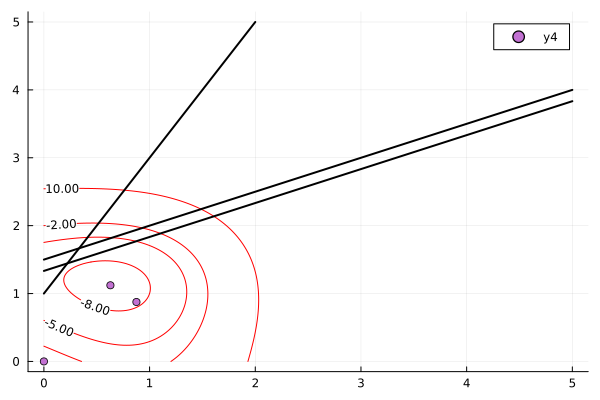

In [145]:
scatter!([liste_iteres[i][1] for i in 1:3], [liste_iteres[i][2] for i in 1:3])

In [3]:
function ∂f(x, ϵ = 10^-10)
    df = ones(length(x))
    i = 1
    for z in x
        if z < -ϵ
            df[i] = -1
        end
        i += 1
    end
    return df
end

∂f (generic function with 2 methods)

In [8]:
∂f([-1,0,5, -4])

4-element Vector{Float64}:
 -1.0
  1.0
  1.0
 -1.0

$$f(x) = \max_{1\leqslan i\leqslant n}|x_i|$$ 

In [18]:
# f = [f1, ..., fm]
function fmax(f, df, x)
    z = zeros(length(x))
    i = findmax(f(x))[2]
    return df(x)[i]
end

fmax (generic function with 3 methods)

In [33]:
function fmax(g,dg,x)
     fx,i =  findmax(g(x))
end


fmax (generic function with 3 methods)

In [34]:
fmax(2)

(7, 2)

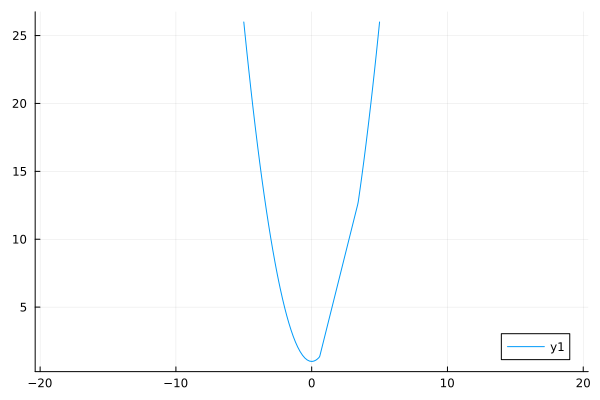

In [36]:
plot(x -> fmax(x)[1], aspect_ratio=:equal)

In [ ]:


function zouteindijk_linear(f, df, A, b, Q, c, x0, ϵ, itermax=20)
   
    ρ = 0.01
    i = 1
    x = deepcopy(x0)
    n = length(x0)
    liste_iteres = [x]
    mon_modele = Model(GLPK.Optimizer)
    @variable(mon_modele, -1 .<= d[1:n] .<= 1)
    if Q != []
        @constraint(mon_modele, Q*d .== 0)
    end
    
    while i< itermax
        # Déterminer les contraintes actives
        ind = findall(abs.(A*x-b) .<= ρ)
        println("ind = $ind")
        A1 = A[ind, :]
        b1 = b[ind]
        A2 = A[setdiff(1:4, ind),:]
        b2 = b[setdiff(1:4,ind)];
        
        set_objective_function(mon_modele, df(x)'*d)
        @constraint(mon_modele, cons, A1*d .<= 0)
        optimize!(mon_modele)
        
        # Calcul de alphamax
        hd = A2*value.(d)
        hb = (b2-A2*x)[hd .> 0]
        hd = hd[hd .> 0]
        α_max = hb != [] ? minimum(hb ./ hd) : 100
        
        # Calcul de alpha
        ϕ(t) = f(x0+t*value.(d))
        res = Optim.optimize(ϕ, 0, α_max, GoldenSection())
        α = Optim.minimizer(res)
        
        # mise à jour de la solution
        x = x+α*value.(d)
        append!(liste_iteres, [x])
        
        if abs(df(x0)'*value.(d))<ϵ 
            return x0, f(x0), liste_iteres
        end
        
        unregister(mon_modele,:cons)
        delete(mon_modele, cons)
        i += 1
    end
    
end

In [15]:
function zouteindijk_linear(f, df, A, b, Q, c, x0, ϵ, itermax=20)
   
    ρ = 0.01
    i = 1
    x = deepcopy(x0)
    n = length(x0)
    liste_iteres = [x]
    mon_modele = Model(GLPK.Optimizer)
    @variable(mon_modele, -1 .<= d[1:n] .<= 1)
    if Q != []
        @constraint(mon_modele, Q*d .== 0)
    end
    
    while i< itermax
        # Déterminer les contraintes actives
        ind = findall(abs.(A*x-b) .<= ρ)
        println("ind = $ind")
        A1 = A[ind, :]
        b1 = b[ind]
        A2 = A[setdiff(1:4, ind),:]
        b2 = b[setdiff(1:4,ind)];
        
        set_objective_function(mon_modele, df(x)'*d)
        @constraint(mon_modele, cons, A1*d .<= 0)
        optimize!(mon_modele)
        
        # Calcul de alphamax
        hd = A2*value.(d)
        hb = (b2-A2*x)[hd .> 0]
        hd = hd[hd .> 0]
        α_max = hb != [] ? minimum(hb ./ hd) : 100
        
        # Calcul de alpha
        ϕ(t) = f(x0+t*value.(d))
        res = Optim.optimize(ϕ, 0, α_max, GoldenSection())
        α = Optim.minimizer(res)
        
        # mise à jour de la solution
        x = x+α*value.(d)
        append!(liste_iteres, [x])
        
        if abs(df(x0)'*value.(d))<ϵ 
            return x0, f(x0), liste_iteres
        end
        
        unregister(mon_modele,:cons)
        delete(mon_modele, cons)
        i += 1
    end
    
end

zouteindijk_linear (generic function with 2 methods)

In [16]:
z, u, l = zouteindijk_linear(f, df, A, b, [], [], x0, 0.001, 10)

ind = [3, 4]
ind = Int64[]
ind = [2]
ind = [2]
ind = [2]
ind = [2]
ind = [2]
ind = [2]
ind = [2]


LoadError: MethodError: no method matching iterate(::Nothing)
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:872
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m) at range.jl:872
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}} at dict.jl:712
[0m  ...

In [11]:
using GLPK

In [17]:
liste_themes = ["Méthode du gradient réduit.", 
"Méthode basée sur les approximations linéaires successives",
"Méthode basée sur les approximations quadratiques successives",
"Méthode de pénalisation intérieure.",
"Méthode du Lagrangien augmenté."]

liste_etudiants = ["nihad", "meriem", "soumaya", "bouchra", "amira"]

5-element Vector{String}:
 "nihad"
 "meriem"
 "soumaya"
 "bouchra"
 "amira"

In [19]:
for i in 1:20
    shuffle!(liste_themes)
    shuffle!(liste_etudiants)
end

for i in 1:length(liste_etudiants)
    println("$(liste_etudiants[i]) à le thème $(liste_themes[i]) ")
end

amira à le thème Méthode du Lagrangien augmenté. 
bouchra à le thème Méthode basée sur les approximations quadratiques successives 
soumaya à le thème Méthode du gradient réduit. 
meriem à le thème Méthode basée sur les approximations linéaires successives 
nihad à le thème Méthode de pénalisation intérieure. 


In [18]:
using Random